# Genre Analysis

In [176]:
data_labels = [json.loads(line)['id'] for line in open('../moviescope/test.jsonl')]
data_labels_rating = [json.loads(line)['id'] for line in open('../moviescope/test_rating.jsonl')]
common_data_labels = set(data_labels).intersection(set(data_labels_rating))

common_pred_indexes = []
for i, example_id in enumerate(data_labels):
    if example_id in common_data_labels:
        common_pred_indexes.append(i)

In [177]:
model_path = "moviescope_VideoTextAudioPosterMetaGMUNoEncodersSeed4_mmtr_model_run"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

In [179]:
gates = np.load(f'model_save_mmtr/{model_path}/gates.npy')
all_gates = np.stack([gates[:, 768*i:768*(i+1)] for i in range(8)], axis=1)[common_pred_indexes]

In [180]:
all_gates.shape

(860, 8, 768)

In [181]:
modality_dist = []
threshold = 0.9

for i in range(all_gates.shape[0]):
    example_modality_freq = []
    for j in range(all_gates.shape[1]):
        modality_true_counts = Counter(all_gates[i][j] > threshold)[True]
        example_modality_freq.append(modality_true_counts)
    modality_dist.append(np.array(example_modality_freq))

modality_dist = np.array(modality_dist)

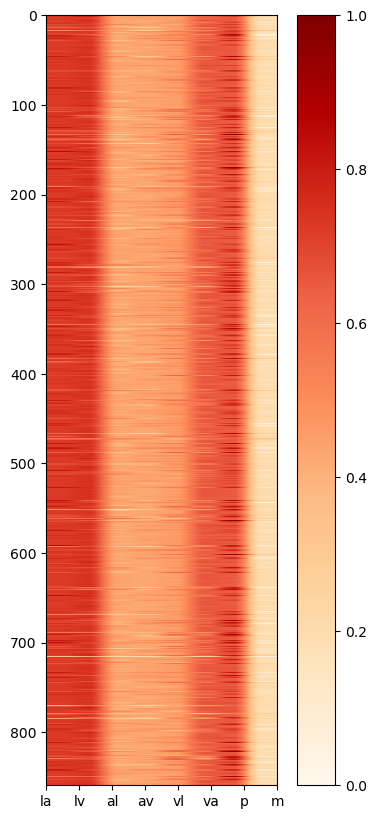

In [182]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

modality_dist_norm = (modality_dist-np.min(modality_dist))/(np.max(modality_dist)-np.min(modality_dist))

img = plt.imshow(modality_dist_norm, extent=[0,7,modality_dist_norm.shape[0]-1,0], cmap='OrRd')
forceAspect(ax, aspect=0.3)
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

In [186]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

model_preds = load_labels(f"model_save_mmtr/{model_path}/test_labels_gold.txt")[common_pred_indexes]
ground_truth_labels = load_labels(f"model_save_mmtr/{model_path}/test_labels_pred.txt")[common_pred_indexes]
with open(f"model_save_mmtr/{model_path}/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")

In [187]:
preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
preds_equal_eval = np.array(preds_equal_eval)

correct_indexes = np.argwhere(preds_equal_eval == True)
correct_indexes = np.squeeze(correct_indexes, axis=1)

correct_modality_dist = modality_dist[correct_indexes]

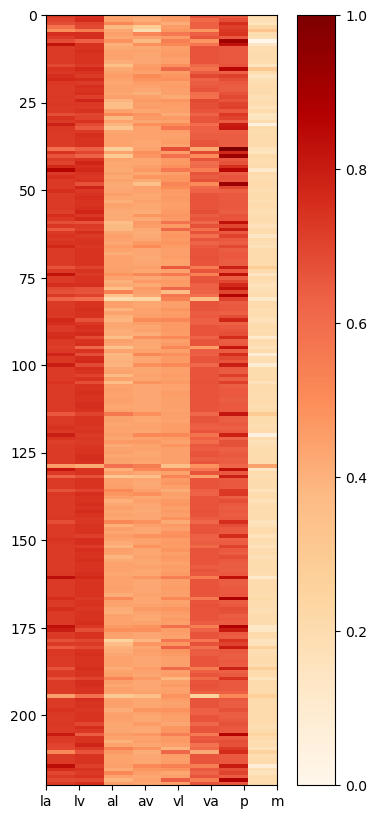

In [188]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

correct_modality_dist_norm = (correct_modality_dist-np.min(correct_modality_dist))/(np.max(correct_modality_dist)-np.min(correct_modality_dist))

img = plt.imshow(correct_modality_dist_norm, extent=[0,7,correct_modality_dist_norm.shape[0]-1,0], cmap='OrRd')
forceAspect(ax, aspect=0.3)
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

In [189]:
genre_rates = np.zeros((len(label_names), 8))

for i, lable in enumerate(label_names):
    # get genre position
    genre_idx = label_names.index(lable)

    # Filter test examples that include that genre
    genre_examples_idx = np.argwhere((ground_truth_labels[:, genre_idx] == 1) == True)
    genre_examples_idx = np.squeeze(genre_examples_idx, axis=1)
    genre_modality_dist = modality_dist[genre_examples_idx]
    
    # Compute proportion of activations per modality
    genre_rates[i] = np.mean(genre_modality_dist, axis=0)

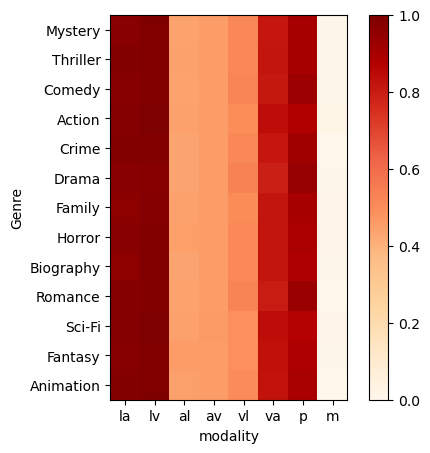

In [190]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(7,5)
ax = fig.add_subplot(111)

selected_idxs = [i for i in range(len(label_names))]
selected_label_names = [label_names[idx] for idx in selected_idxs]

genre_rates_norm = (genre_rates-np.min(genre_rates))/(np.max(genre_rates)-np.min(genre_rates))

fig_width = 8
img = plt.imshow(genre_rates_norm[selected_idxs], extent=[0,fig_width,genre_rates_norm[selected_idxs].shape[0],0], cmap='OrRd')
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticklabels(modality_xticks);
plt.yticks(range(len(selected_label_names)), selected_label_names);
ax.set_xticks([fig_width/16*i for i in range(1, 17, 2)])
ax.set_yticks([i*0.5 for i in range(1, 27, 2)])
ax.set_xlabel('modality');
ax.set_ylabel('Genre');
plt.colorbar(img, fraction=0.046, pad=0.04);

### Get highest or lowest example index activatons per modality

In [78]:
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [79]:
def get_extreme_index(modality_name, func, modality_dist):
    modality_txt2idx = {'la':0, 'lv':1, 'al':2, 'av':3, 'vl':4, 'va':5, 'p':6, 'm':7}
    
    return func(modality_dist[:, modality_txt2idx[modality_name]])

In [81]:
metadata_df = pd.read_csv('../moviescope/movie_metadata.csv')
data_labels = [json.loads(line) for line in open('../moviescope/test_rating.jsonl')]

with open(f"model_save_mmtr/{model_path}/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")
    
model_preds = load_labels(f"model_save_mmtr/{model_path}/test_labels_pred.txt")

### Get highest or lowest example index activatons per modality for correct predictions

In [401]:
example_id = get_extreme_index("la", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Comedy'],
 'id': 2714,
 'synopsis': '{{Plot}} Robert "Fish" Fishman  was the drummer for Vesuvius, a local heavy metal/glam metal band from Cleveland, Ohio. After playing a local gig, Fish\'s bandmates are approached by their manager, who says that a label is interested in them but will not sign them unless they get rid of Fish. The band agrees. Twenty years later, Fish leads an unhappy life by failing at another cubicle job, breaking up with his girlfriend, and having to move in with his sister , her husband, and two kids. Fish finds himself living in the attic looking for work. Matt , Fish\'s nephew, plays keyboard in an alternative rock band called A.D.D., joined by the dark, brooding Curtis  and the no-nonsense Amelia . The band is set to play at the prom, but when their drummer gets thrown out of school, they search for a new one but with little to no success. They agree to ask Fish to play drums at their "gig" for only the one time. The prom turns into a disaster, bei

In [402]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 860


In [403]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                   Peter Cattaneo
num_critic_for_reviews                                                     132
duration                                                                   102
director_facebook_likes                                                     11
actor_3_facebook_likes                                                    1000
actor_2_name                                                    Bradley Cooper
actor_1_facebook_likes                                                   15000
gross                                                              6.40921e+06
genres                                                            Comedy|Music
actor_1_name                                                        Emma Stone
movie_title                                                        The Rocker 
num_voted_users                                     

In [404]:
model_label_preds = []

for i, value in enumerate(model_preds[correct_indexes[example_id]]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels = metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels)

Predicted labels:  ['Comedy']
Ground truth labels:  ['Comedy', 'Music']


In [405]:
correct_modality_dist[example_id]

array([428, 417, 378, 383, 394, 392, 427, 344])

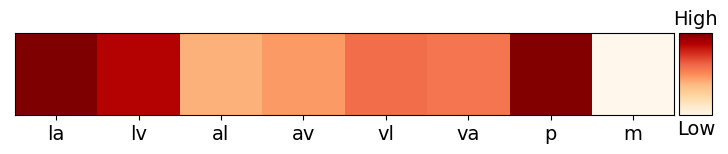

In [406]:
example_modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.add_subplot(111)

img = plt.imshow(example_modality_dist, cmap='OrRd')
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
plt.xticks(fontsize=14)
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center', fontsize=14)
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center', fontsize=14);

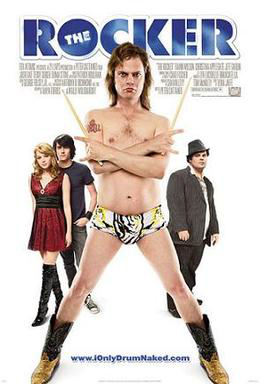

In [407]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/home/est_posgrado_isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

# Rating Analysis

In [165]:
model_path_rating = "rating_VideoTextAudioPosterMetaGMUNoEncodersSeed3_mmtr_model_run"

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl

In [167]:
gates_rating = np.load(f'model_save_mmtr/{model_path_rating}/gates.npy')
all_gates_rating = np.stack([gates_rating[:, 768*i:768*(i+1)] for i in range(8)], axis=1)

In [169]:
modality_dist_rating = []
threshold = 0.9

for i in range(all_gates_rating.shape[0]):
    example_modality_freq = []
    for j in range(all_gates_rating.shape[1]):
        modality_true_counts = Counter(all_gates_rating[i][j] > threshold)[True]
        example_modality_freq.append(modality_true_counts)
    modality_dist_rating.append(np.array(example_modality_freq))

modality_dist_rating = np.array(modality_dist_rating)

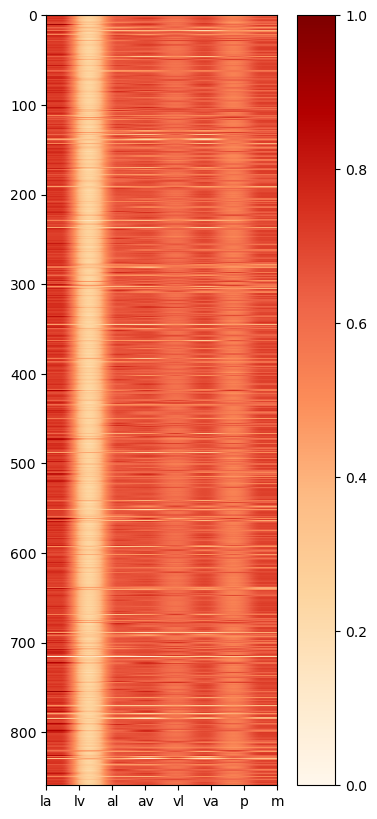

In [170]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

modality_dist_rating_norm = (modality_dist_rating-np.min(modality_dist_rating))/(np.max(modality_dist_rating)-np.min(modality_dist_rating))

img = plt.imshow(modality_dist_rating_norm, extent=[0,7,modality_dist_rating_norm.shape[0]-1,0], cmap='OrRd')
forceAspect(ax, aspect=0.3)
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

In [171]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

model_preds_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_gold.txt")
ground_truth_labels_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_pred.txt")
with open(f"model_save_mmtr/{model_path_rating}/test_labels.txt", "r") as f:
    label_names_rating = f.readlines()[0].split(" ")

In [172]:
preds_equal_eval_rating = list(map(np.all, np.equal(model_preds_rating, ground_truth_labels_rating)))
preds_equal_eval_rating = np.array(preds_equal_eval_rating)

correct_indexes_rating = np.argwhere(preds_equal_eval_rating == True)
correct_indexes_rating = np.squeeze(correct_indexes_rating, axis=1)

correct_modality_dist_rating = modality_dist_rating[correct_indexes_rating]

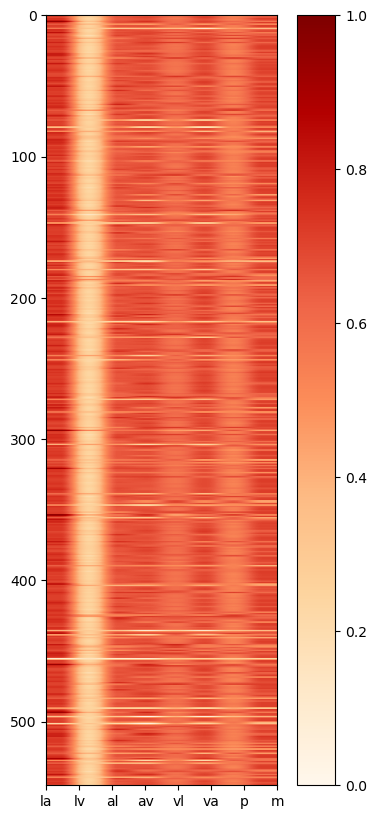

In [173]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

correct_modality_dist_rating_norm = (correct_modality_dist_rating-np.min(correct_modality_dist_rating))/(np.max(correct_modality_dist_rating)-np.min(correct_modality_dist_rating))

img = plt.imshow(correct_modality_dist_rating_norm, extent=[0,7,correct_modality_dist_rating_norm.shape[0]-1,0], cmap='OrRd')
forceAspect(ax, aspect=0.3)
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

In [174]:
rating_rates = np.zeros((5, 8))

for i, lable in enumerate(label_names_rating):
    # get genre position
    genre_idx = label_names_rating.index(lable)

    # Filter test examples that include that genre
    genre_examples_idx = np.argwhere((ground_truth_labels_rating == genre_idx) == True)[:, 0]
    #genre_examples_idx = np.squeeze(genre_examples_idx, axis=1)
    genre_modality_dist = modality_dist[genre_examples_idx]
    
    # Compute proportion of activations per modality
    rating_rates[i] = np.mean(genre_modality_dist, axis=0)

# No test observations for this class
rating_rates = np.delete(rating_rates, label_names_rating.index('NC-17'), axis=0)
label_names_rating.remove('NC-17')

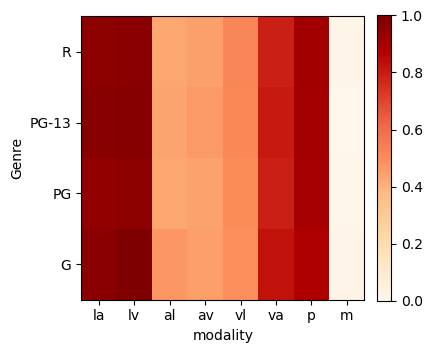

In [175]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(4,5)
ax = fig.add_subplot(111)

selected_idxs = [i for i in range(len(label_names_rating))]
selected_label_names_rating = [label_names_rating[idx] for idx in selected_idxs]

rating_rates_norm = (rating_rates-np.min(rating_rates))/(np.max(rating_rates)-np.min(rating_rates))

img = plt.imshow(rating_rates_norm[selected_idxs], extent=[0,3,rating_rates_norm[selected_idxs].shape[0]-1,0], cmap='OrRd')
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_xticklabels(modality_xticks);
plt.yticks(range(len(selected_label_names_rating)), selected_label_names_rating);
ax.set_xticks([3/16*i for i in range(1, 17, 2)])
ax.set_yticks([3/8*i for i in range(1, 9, 2)])
ax.set_xlabel('modality');
ax.set_ylabel('Genre');
plt.colorbar(img, fraction=0.046, pad=0.04);

### Get highest or lowest example index activatons per modality

In [78]:
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [79]:
def get_extreme_index(modality_name, func, modality_dist):
    modality_txt2idx = {'la':0, 'lv':1, 'al':2, 'av':3, 'vl':4, 'va':5, 'p':6, 'm':7}
    
    return func(modality_dist[:, modality_txt2idx[modality_name]])

In [81]:
metadata_df = pd.read_csv('../moviescope/movie_metadata.csv')
data_labels = [json.loads(line) for line in open('../moviescope/test_rating.jsonl')]

with open(f"model_save_mmtr/{model_path_rating}/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")
    
model_preds_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_pred.txt")

### Get highest or lowest example index activatons per modality for correct predictions

In [401]:
example_id = get_extreme_index("la", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Comedy'],
 'id': 2714,
 'synopsis': '{{Plot}} Robert "Fish" Fishman  was the drummer for Vesuvius, a local heavy metal/glam metal band from Cleveland, Ohio. After playing a local gig, Fish\'s bandmates are approached by their manager, who says that a label is interested in them but will not sign them unless they get rid of Fish. The band agrees. Twenty years later, Fish leads an unhappy life by failing at another cubicle job, breaking up with his girlfriend, and having to move in with his sister , her husband, and two kids. Fish finds himself living in the attic looking for work. Matt , Fish\'s nephew, plays keyboard in an alternative rock band called A.D.D., joined by the dark, brooding Curtis  and the no-nonsense Amelia . The band is set to play at the prom, but when their drummer gets thrown out of school, they search for a new one but with little to no success. They agree to ask Fish to play drums at their "gig" for only the one time. The prom turns into a disaster, bei

In [402]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 860


In [403]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                   Peter Cattaneo
num_critic_for_reviews                                                     132
duration                                                                   102
director_facebook_likes                                                     11
actor_3_facebook_likes                                                    1000
actor_2_name                                                    Bradley Cooper
actor_1_facebook_likes                                                   15000
gross                                                              6.40921e+06
genres                                                            Comedy|Music
actor_1_name                                                        Emma Stone
movie_title                                                        The Rocker 
num_voted_users                                     

In [404]:
model_label_preds = []

for i, value in enumerate(model_preds_rating[correct_indexes[example_id]]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels_rating = metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels_rating)

Predicted labels:  ['Comedy']
Ground truth labels:  ['Comedy', 'Music']


In [405]:
correct_modality_dist[example_id]

array([428, 417, 378, 383, 394, 392, 427, 344])

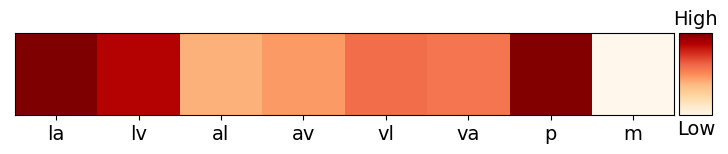

In [406]:
example_modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.add_subplot(111)

img = plt.imshow(example_modality_dist, cmap='OrRd')
modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
plt.xticks(fontsize=14)
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center', fontsize=14)
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center', fontsize=14);

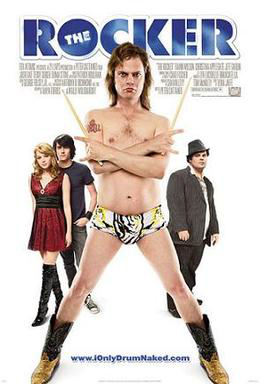

In [407]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/home/est_posgrado_isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

# Common correct predictions

In [229]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import pandas as pd

plt.style.use('default')

Get common observations in both test sets

In [230]:
data_labels = [json.loads(line)['id'] for line in open('../moviescope/test.jsonl')]
data_labels_rating = [json.loads(line)['id'] for line in open('../moviescope/test_rating.jsonl')]
common_data_labels = set(data_labels).intersection(set(data_labels_rating))

common_pred_indexes = []
for i, example_id in enumerate(data_labels):
    if example_id in common_data_labels:
        common_pred_indexes.append(i)

In [231]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

Load genre classification test GMU gates

In [250]:
model_path_genre = "moviescope_VideoTextAudioPosterMetaGMUNoEncodersSeed4_mmtr_model_run"
gates = np.load(f'model_save_mmtr/{model_path_genre}/gates.npy')
all_gates_genre = np.stack([gates[:, 768*i:768*(i+1)] for i in range(8)], axis=1)[common_pred_indexes]
with open(f"model_save_mmtr/{model_path_genre}/test_labels.txt", "r") as f:
    genre_names = f.readlines()[0].split(" ")

Load rating classification test GMU gates

In [251]:
model_path_rating = "rating_VideoTextAudioPosterMetaGMUNoEncodersNewSeed4_mmtr_model_run"
gates_rating = np.load(f'model_save_mmtr/{model_path_rating}/gates.npy')
all_gates_rating = np.stack([gates_rating[:, 768*i:768*(i+1)] for i in range(8)], axis=1)
with open(f"model_save_mmtr/{model_path_rating}/test_labels.txt", "r") as f:
    rating_names = f.readlines()[0].split(" ")

Function to get intersection of correct test predicitons in both rating and genre classification

In [252]:
def get_correct_indexes(path1, path2, common_pred_indexes):
    def load_labels(path):
        with open(path, "r") as f:
            all_preds = f.readlines()
        preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
        return np.array(preds_processed)

    data_genre = [json.loads(line) for line in open('../moviescope/test.jsonl')]
    data_genre = [data_genre[i] for i in common_pred_indexes]
    ground_truth_labels = load_labels(f"model_save_mmtr/{path1}/test_labels_gold.txt")[common_pred_indexes]
    model_preds = load_labels(f"model_save_mmtr/{path1}/test_labels_pred.txt")[common_pred_indexes]
    preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
    preds_equal_eval = np.array(preds_equal_eval)
    correct_indexes = np.argwhere(preds_equal_eval == True)
    correct_indexes1 = np.squeeze(correct_indexes, axis=1)
    
    data_rating = [json.loads(line) for line in open('../moviescope/test_rating.jsonl')]
    ground_truth_labels = load_labels(f"model_save_mmtr/{path2}/test_labels_gold.txt")
    model_preds = load_labels(f"model_save_mmtr/{path2}/test_labels_pred.txt")
    preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
    preds_equal_eval = np.array(preds_equal_eval)
    correct_indexes = np.argwhere(preds_equal_eval == True)
    correct_indexes2 = np.squeeze(correct_indexes, axis=1)
    
    return list(set(correct_indexes1).intersection(set(correct_indexes2))), data_genre, data_rating

Total number of common correct predictions

In [253]:
common_correct, data_genre, data_rating = get_correct_indexes(model_path_genre, model_path_rating, common_pred_indexes)
common_correct.sort()
print(len(common_correct))

148


In [254]:
all_gates_genre = all_gates_genre[common_correct]
all_gates_rating = all_gates_rating[common_correct]

data_genre = [data_genre[i] for i in common_correct]
data_rating = [data_rating[i] for i in common_correct]

In [255]:
ground_truth_labels_genre = load_labels(f"model_save_mmtr/{model_path_genre}/test_labels_gold.txt")[common_pred_indexes][common_correct]
model_preds_genre = load_labels(f"model_save_mmtr/{model_path_genre}/test_labels_pred.txt")[common_pred_indexes][common_correct]

ground_truth_labels_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_gold.txt")[common_correct]
model_preds_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_pred.txt")[common_correct]

Get GMU distribution matrix for both rating and genre

In [256]:
def get_modality_dist(gates_matrix, threshold_val=0.9):
    modality_dist = []
    threshold = threshold_val

    for i in range(gates_matrix.shape[0]):
        example_modality_freq = []
        for j in range(gates_matrix.shape[1]):
            modality_true_counts = Counter(gates_matrix[i][j] > threshold)[True]
            example_modality_freq.append(modality_true_counts)
        modality_dist.append(np.array(example_modality_freq))

    return np.array(modality_dist)

In [257]:
modality_dist_genre = get_modality_dist(all_gates_genre)
modality_dist_rating = get_modality_dist(all_gates_rating)

Plot both GMU distribution matrices

In [258]:
def plot_dist(modality_dist, w=5, h=5, force=True, h_d=0, fig_width=8, class_names=None):
    def forceAspect(ax,aspect):
        im = ax.get_images()
        extent =  im[0].get_extent()
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    fig = plt.figure()
    fig.set_size_inches(w,h)
    ax = fig.add_subplot(111)

    modality_dist_norm = (modality_dist-np.min(modality_dist))/(np.max(modality_dist)-np.min(modality_dist))
    
    fig_height = modality_dist_norm.shape[0]-h_d
    img = plt.imshow(modality_dist_norm, extent=[0,fig_width,fig_height,0], cmap='OrRd')
    if force:
        forceAspect(ax, aspect=0.5)
    
    modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
    ax.set_xticklabels(modality_xticks);
    ax.set_xticks([fig_width/16*i for i in range(1, 17, 2)])
    if class_names:
        plt.yticks(range(len(class_names)), class_names);
        ax.set_yticks([fig_height/(len(class_names)*2)*i for i in range(1, len(class_names)*2+1, 2)])
    
    ax.set_xlabel('modality');
    plt.colorbar(img, fraction=0.046, pad=0.04);

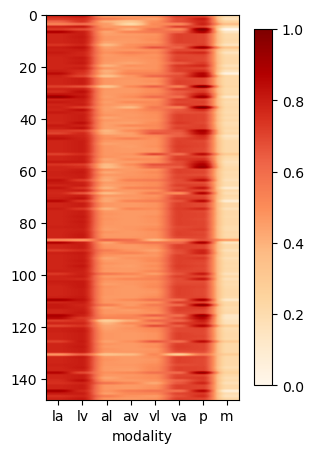

In [259]:
plot_dist(modality_dist_genre)

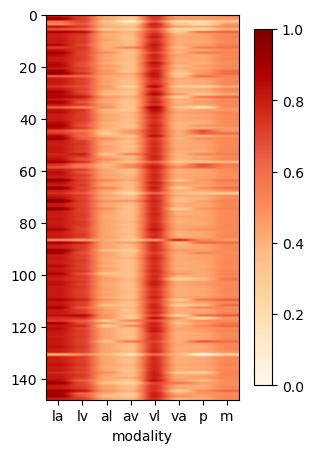

In [260]:
plot_dist(modality_dist_rating)

### Global distribution per category

In [261]:
def get_category_modality_dist(modality_dist, label_names, ground_truth_labels):
    modality_dist_matrix = np.zeros((len(label_names), modality_dist.shape[1]))

    for i, lable in enumerate(label_names):
        # get genre position
        category_idx = label_names.index(lable)

        # Filter test examples that include that category
        if len(label_names) < 6:
            category_examples_idx = np.argwhere((ground_truth_labels_rating == category_idx) == True)[:, 0]
        else:
            category_examples_idx = np.argwhere((ground_truth_labels[:, category_idx] == 1) == True)
            category_examples_idx = np.squeeze(category_examples_idx, axis=1)
        
        category_dist = modality_dist[category_examples_idx]

        # Compute proportion of activations per modality
        modality_dist_matrix[i] = np.mean(category_dist, axis=0)
    
    if len(label_names) < 6:
        # No test observations for this class
        modality_dist_matrix = np.delete(modality_dist_matrix, label_names.index('NC-17'), axis=0)
        label_names.remove('NC-17')
    
    return modality_dist_matrix

In [262]:
modality_dist_genre_global = get_category_modality_dist(modality_dist_genre, genre_names, ground_truth_labels_genre)
modality_dist_rating_global = get_category_modality_dist(modality_dist_rating, rating_names, ground_truth_labels_rating)

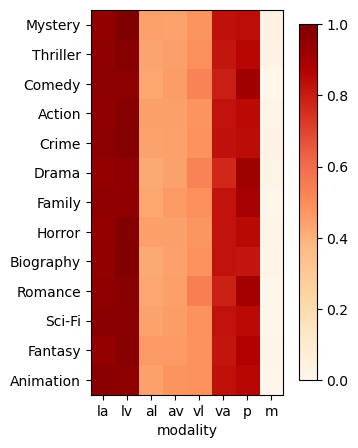

In [263]:
plot_dist(modality_dist_genre_global, class_names=genre_names)

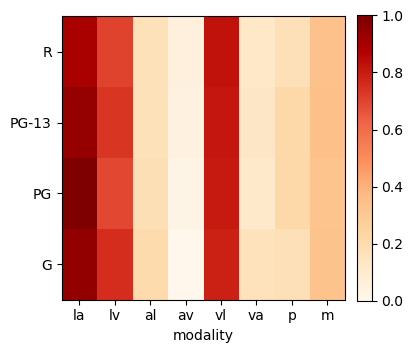

In [264]:
plot_dist(modality_dist_rating_global, force=False, w=4, h_d=1, fig_width=3, class_names=rating_names)

### Get highest or lowest example index activatons per modality

#### Genre classification

In [269]:
from IPython.display import display
from PIL import Image

In [270]:
def get_extreme_index(modality_name, func, modality_dist):
    modality_txt2idx = {'la':0, 'lv':1, 'al':2, 'av':3, 'vl':4, 'va':5, 'p':6, 'm':7}
    
    return func(modality_dist[:, modality_txt2idx[modality_name]])

metadata_df = pd.read_csv('../moviescope/movie_metadata.csv')

In [271]:
def plot_example_activations(example_dist, title):
    example_modality_dist = example_dist[np.newaxis, ...]/np.sum(example_dist)

    fig = plt.figure()
    fig.set_size_inches(9,9)
    ax = fig.add_subplot(111)

    img = plt.imshow(example_modality_dist, cmap='OrRd')
    modality_xticks = ['la','lv','al','av', 'vl', 'va', 'p', 'm']
    ax.set_yticks([])
    ax.set_xticks(np.arange(len(modality_xticks)))
    plt.xticks(fontsize=14)
    ax.set_xticklabels(modality_xticks);
    
    ax.set_title(title, loc='center')

    # Adjust colorbar size to match figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(img, cax=cax)
    # Remove minor ticks in colorbar
    cbar.set_ticks([])
    # Add text labels at top and bottom of colorbar
    cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
        va='top', ha='center', fontsize=14)
    cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
        va='bottom', ha='center', fontsize=14);
    
    # Place values inside cell

    for x_index, x in enumerate(example_modality_dist[0]):
        ax.text(x_index, 0, f'{x:.4}', color='black', ha='center', va='center')

In [272]:
example_id = get_extreme_index("la", np.argmax, modality_dist_genre)
data_genre[example_id]

{'label': ['Comedy'],
 'id': 2714,
 'synopsis': '{{Plot}} Robert "Fish" Fishman  was the drummer for Vesuvius, a local heavy metal/glam metal band from Cleveland, Ohio. After playing a local gig, Fish\'s bandmates are approached by their manager, who says that a label is interested in them but will not sign them unless they get rid of Fish. The band agrees. Twenty years later, Fish leads an unhappy life by failing at another cubicle job, breaking up with his girlfriend, and having to move in with his sister , her husband, and two kids. Fish finds himself living in the attic looking for work. Matt , Fish\'s nephew, plays keyboard in an alternative rock band called A.D.D., joined by the dark, brooding Curtis  and the no-nonsense Amelia . The band is set to play at the prom, but when their drummer gets thrown out of school, they search for a new one but with little to no success. They agree to ask Fish to play drums at their "gig" for only the one time. The prom turns into a disaster, bei

In [273]:
print(f"Plot length: {len(data_genre[example_id]['synopsis'].split(' '))}")

Plot length: 860


In [274]:
metadata_df.iloc[data_genre[example_id]['id']]

color                                                                    Color
director_name                                                   Peter Cattaneo
num_critic_for_reviews                                                     132
duration                                                                   102
director_facebook_likes                                                     11
actor_3_facebook_likes                                                    1000
actor_2_name                                                    Bradley Cooper
actor_1_facebook_likes                                                   15000
gross                                                              6.40921e+06
genres                                                            Comedy|Music
actor_1_name                                                        Emma Stone
movie_title                                                        The Rocker 
num_voted_users                                     

In [275]:
modality_dist_genre[example_id]

array([428, 417, 378, 383, 394, 392, 427, 344])

In [ ]:
plot_example_activations(modality_dist_genre[example_id])

In [277]:
modality_dist_rating[example_id]

array([415, 410, 380, 373, 404, 362, 387, 392])

In [ ]:
plot_example_activations(modality_dist_rating[example_id])

In [ ]:
poster_id = str(data_genre[example_id]['id'])
display(Image.open('/home/est_posgrado_isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

### Examples with highest difference in specific modality

In [280]:
modality_txt2idx = {'la':0, 'lv':1, 'al':2, 'av':3, 'vl':4, 'va':5, 'p':6, 'm':7}

In [403]:
modality_index = modality_txt2idx['m']
example_id = np.argmax(abs(modality_dist_genre[:,modality_index]-modality_dist_rating[:,modality_index]))
data_genre[example_id]

{'label': ['Comedy', 'Drama'],
 'id': 3297,
 'synopsis': "After drifting apart emotionally over the years, two single siblings — Wendy  and Jon  — band together to care for their estranged, elderly father, Lenny , who is rapidly slipping into dementia. Wendy and Jon first travel to Sun City, Arizona, to attend the funeral of their father's girlfriend of 20 years. When they arrive, they are told that their father signed a non-marriage agreement and will not have rights to any of her property. They then move him to a nursing home in Buffalo, New York, where Jon is a theater professor working on a book about Bertolt Brecht. Wendy, who is an aspiring, but unsuccessful, playwright, moves from New York City to help establish their father in Buffalo. Neither is close with Lenny, who is said to have been a difficult man to live with.  Their dysfunctional family life appears to have left Wendy and Jon emotionally crippled and unable to sustain a relationship. She is sleeping with an unattainabl

In [404]:
metadata_df.iloc[data_genre[example_id]['id']]

color                                                                    Color
director_name                                                   Tamara Jenkins
num_critic_for_reviews                                                     201
duration                                                                   114
director_facebook_likes                                                     84
actor_3_facebook_likes                                                     338
actor_2_name                                                       David Zayas
actor_1_facebook_likes                                                   22000
gross                                                              6.61033e+06
genres                                                            Comedy|Drama
actor_1_name                                            Philip Seymour Hoffman
movie_title                                                       The Savages 
num_voted_users                                     

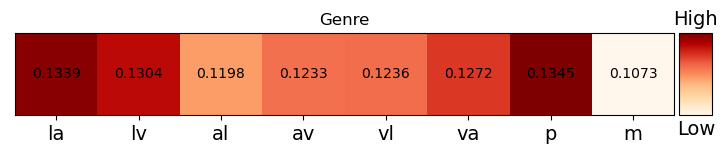

In [405]:
plot_example_activations(modality_dist_genre[example_id], "Genre")

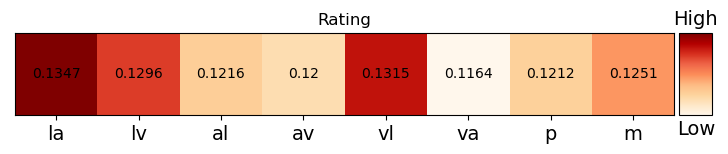

In [406]:
plot_example_activations(modality_dist_rating[example_id], "Rating")

In [407]:
modality_dist_rating[example_id]

array([421, 405, 380, 375, 411, 364, 379, 391])

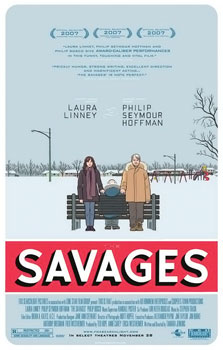

In [408]:
poster_id = str(data_genre[example_id]['id'])
display(Image.open('/home/est_posgrado_isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

# Common correct predictions Few modalities

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
import pandas as pd

plt.style.use('default')

Get common observations in both test sets

In [3]:
data_labels = [json.loads(line)['id'] for line in open('../moviescope/test.jsonl')]
data_labels_rating = [json.loads(line)['id'] for line in open('../moviescope/test_rating.jsonl')]
common_data_labels = set(data_labels).intersection(set(data_labels_rating))

common_pred_indexes = []
for i, example_id in enumerate(data_labels):
    if example_id in common_data_labels:
        common_pred_indexes.append(i)

In [4]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

Load genre classification test GMU gates

In [48]:
model_path_genre = "moviescope_VideoTextAudioGMUNoEncoderSeed2_mmtr_model_run"
gates = np.load(f'model_save_mmtr/{model_path_genre}/gates.npy')
all_gates_genre = np.stack([gates[:, 768*i:768*(i+1)] for i in range(6)], axis=1)[common_pred_indexes]
with open(f"model_save_mmtr/{model_path_genre}/test_labels.txt", "r") as f:
    genre_names = f.readlines()[0].split(" ")

Load rating classification test GMU gates

In [49]:
model_path_rating = "moviescope_VideoTextAudioGMUNoEncoderSeed2_mmtr_model_run"
gates_rating = np.load(f'model_save_mmtr/{model_path_rating}/gates.npy')
all_gates_rating = np.stack([gates_rating[:, 768*i:768*(i+1)] for i in range(6)], axis=1)
with open(f"model_save_mmtr/{model_path_rating}/test_labels.txt", "r") as f:
    rating_names = f.readlines()[0].split(" ")

Function to get intersection of correct test predicitons in both rating and genre classification

In [50]:
def get_correct_indexes(path1, path2, common_pred_indexes):
    def load_labels(path):
        with open(path, "r") as f:
            all_preds = f.readlines()
        preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
        return np.array(preds_processed)

    data_genre = [json.loads(line) for line in open('../moviescope/test.jsonl')]
    data_genre = [data_genre[i] for i in common_pred_indexes]
    ground_truth_labels = load_labels(f"model_save_mmtr/{path1}/test_labels_gold.txt")[common_pred_indexes]
    model_preds = load_labels(f"model_save_mmtr/{path1}/test_labels_pred.txt")[common_pred_indexes]
    preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
    preds_equal_eval = np.array(preds_equal_eval)
    correct_indexes = np.argwhere(preds_equal_eval == True)
    correct_indexes1 = np.squeeze(correct_indexes, axis=1)
    
    data_rating = [json.loads(line) for line in open('../moviescope/test_rating.jsonl')]
    ground_truth_labels = load_labels(f"model_save_mmtr/{path2}/test_labels_gold.txt")
    model_preds = load_labels(f"model_save_mmtr/{path2}/test_labels_pred.txt")
    preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
    preds_equal_eval = np.array(preds_equal_eval)
    correct_indexes = np.argwhere(preds_equal_eval == True)
    correct_indexes2 = np.squeeze(correct_indexes, axis=1)
    
    return list(set(correct_indexes1).intersection(set(correct_indexes2))), data_genre, data_rating

Total number of common correct predictions

In [51]:
common_correct, data_genre, data_rating = get_correct_indexes(model_path_genre, model_path_rating, common_pred_indexes)
common_correct.sort()
print(len(common_correct))

51


In [52]:
all_gates_genre = all_gates_genre[common_correct]
all_gates_rating = all_gates_rating[common_correct]

data_genre = [data_genre[i] for i in common_correct]
data_rating = [data_rating[i] for i in common_correct]

In [53]:
ground_truth_labels_genre = load_labels(f"model_save_mmtr/{model_path_genre}/test_labels_gold.txt")[common_pred_indexes][common_correct]
model_preds_genre = load_labels(f"model_save_mmtr/{model_path_genre}/test_labels_pred.txt")[common_pred_indexes][common_correct]

ground_truth_labels_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_gold.txt")[common_correct]
model_preds_rating = load_labels(f"model_save_mmtr/{model_path_rating}/test_labels_pred.txt")[common_correct]

Get GMU distribution matrix for both rating and genre

In [54]:
def get_modality_dist(gates_matrix, threshold_val=0.9):
    modality_dist = []
    threshold = threshold_val

    for i in range(gates_matrix.shape[0]):
        example_modality_freq = []
        for j in range(gates_matrix.shape[1]):
            modality_true_counts = Counter(gates_matrix[i][j] > threshold)[True]
            example_modality_freq.append(modality_true_counts)
        modality_dist.append(np.array(example_modality_freq))

    return np.array(modality_dist)

In [55]:
modality_dist_genre = get_modality_dist(all_gates_genre)
modality_dist_rating = get_modality_dist(all_gates_rating)

Plot both GMU distribution matrices

In [57]:
def plot_dist(modality_dist, w=5, h=5, force=True, h_d=0, fig_width=6, class_names=None):
    def forceAspect(ax,aspect):
        im = ax.get_images()
        extent =  im[0].get_extent()
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    fig = plt.figure()
    fig.set_size_inches(w,h)
    ax = fig.add_subplot(111)

    modality_dist_norm = (modality_dist-np.min(modality_dist))/(np.max(modality_dist)-np.min(modality_dist))
    
    fig_height = modality_dist_norm.shape[0]-h_d
    img = plt.imshow(modality_dist_norm, extent=[0,fig_width,fig_height,0], cmap='OrRd')
    if force:
        forceAspect(ax, aspect=0.5)
    
    modality_xticks = ['la','lv','al','av', 'vl', 'va']
    ax.set_xticklabels(modality_xticks);
    ax.set_xticks([fig_width/12*i for i in range(1, 13, 2)])
    if class_names:
        plt.yticks(range(len(class_names)), class_names);
        ax.set_yticks([fig_height/(len(class_names)*2)*i for i in range(1, len(class_names)*2+1, 2)])
    
    ax.set_xlabel('modality');
    plt.colorbar(img, fraction=0.046, pad=0.04);

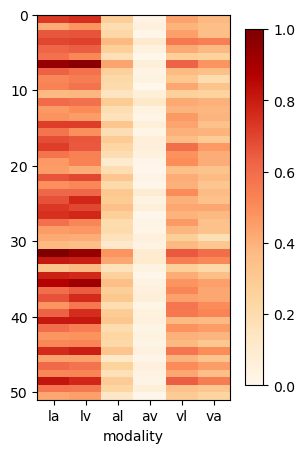

In [58]:
plot_dist(modality_dist_genre)

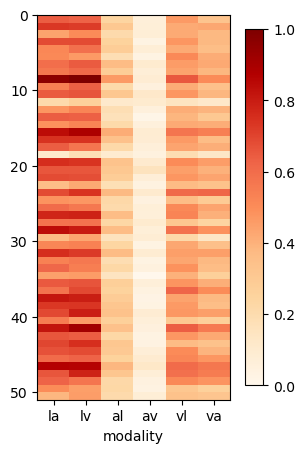

In [59]:
plot_dist(modality_dist_rating)

### Global distribution per category

In [60]:
def get_category_modality_dist(modality_dist, label_names, ground_truth_labels):
    modality_dist_matrix = np.zeros((len(label_names), modality_dist.shape[1]))

    for i, lable in enumerate(label_names):
        # get genre position
        category_idx = label_names.index(lable)

        # Filter test examples that include that category
        if len(label_names) < 6:
            category_examples_idx = np.argwhere((ground_truth_labels_rating == category_idx) == True)[:, 0]
        else:
            category_examples_idx = np.argwhere((ground_truth_labels[:, category_idx] == 1) == True)
            category_examples_idx = np.squeeze(category_examples_idx, axis=1)
        
        category_dist = modality_dist[category_examples_idx]

        # Compute proportion of activations per modality
        modality_dist_matrix[i] = np.mean(category_dist, axis=0)
    
    if len(label_names) < 6:
        # No test observations for this class
        modality_dist_matrix = np.delete(modality_dist_matrix, label_names.index('NC-17'), axis=0)
        label_names.remove('NC-17')
    
    return modality_dist_matrix

In [61]:
modality_dist_genre_global = get_category_modality_dist(modality_dist_genre, genre_names, ground_truth_labels_genre)
modality_dist_rating_global = get_category_modality_dist(modality_dist_rating, rating_names, ground_truth_labels_rating)

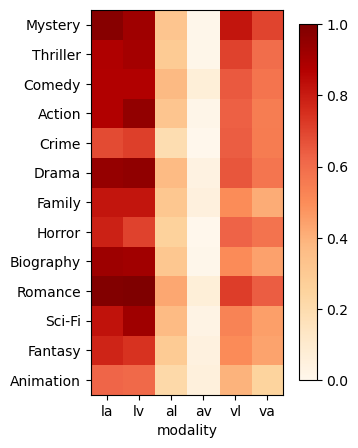

In [62]:
plot_dist(modality_dist_genre_global, class_names=genre_names)

In [ ]:
plot_dist(modality_dist_rating_global, force=False, w=4, h_d=1, fig_width=3, class_names=rating_names)